In [21]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import MatrixProductFunctions as mp
import AuxiliaryFunctions as af
import os
import cmath
import math
from numba import njit
import matplotlib.animation as animation
%matplotlib inline
from ipywidgets import IntProgress, HTML
from IPython.display import display
import pickle
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.linalg import sqrtm
import opt_einsum as oe
import sys
from pympler import asizeof
import socket

In [126]:
os.chdir(af.get_computer_specific_folder())
folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(folder_name, exist_ok=True)
os.chdir(folder_name)
print(f"Все файлы будут сохраняться в: {os.getcwd()}")

Все файлы будут сохраняться в: C:\Users\kaprn\Desktop\MPS_directory\TensorNetworks\2025-10-04_15-40-49


#### Наша задача промоделировать процесс вырожденного спонтанного параметрического рассеяния (DSPDC), гамильтониан этого процесса имеет следующий вид:
$\hat{H} = H_o + H_{spdc} = \hbar w \hat{a}^{\dagger}\hat{a} + \dfrac{\hbar w}{2}\hat{b}^{\dagger}\hat{b} + i\hbar \chi^{(2)}(\hat{a}^{\dagger}\hat{b}\hat{b} - \hat{a}\hat{b}^{\dagger}\hat{b}^{\dagger})$


$H_{spdc} = i\hbar \chi^{(2)}(\hat{a}^{\dagger}\hat{b}\hat{b} - \hat{a}\hat{b}^{\dagger}\hat{b}^{\dagger}) = -i\dfrac{\hbar \chi^{(2)}}{2\sqrt{2}}((\hat{x_a} + \dfrac{d}{dx_a})(\hat{x_b^2} + \dfrac{d^2}{dx_b^2} - \hat{1_b} - 2x_b\dfrac{d}{dx_b}) - (\hat{x_a} - \dfrac{d}{dx_a})(\hat{x_b^2} + \dfrac{d^2}{dx_b^2} + \hat{1_b} + 2x_b\dfrac{d}{dx_b})) = -i\dfrac{\hbar \chi^{(2)}}{2\sqrt{2}}(2\dfrac{d}{dx_a}(\hat{x_b^2} + \dfrac{d^2}{dx_b^2}) - 2\hat{x_a}(\hat{1_b} + 2x_b\dfrac{d}{dx_b})) $

#### Гамильтониан общей энергии системы не привносит интересной физики, поэтому рассматриваем только гамильтониан взаимодействия

$H_{spdc} = i\hbar \chi^{(2)}(\hat{a}^{\dagger}\hat{b}\hat{b} - \hat{a}\hat{b}^{\dagger}\hat{b}^{\dagger}) =$

$-i\dfrac{\hbar \chi^{(2)}}{\sqrt{2}}(\dfrac{d}{dx_a}(\hat{x_b^2} + \dfrac{d^2}{dx_b^2}) - \hat{x_a}(\hat{1_b} + 2\hat{x}_b\dfrac{d}{dx_b}))$

#### Определение параметров

In [ ]:
chi = 1 / 2
theta = 0.001

t_general = 1
steps_number = 1000
delta_t = t_general / steps_number

x_bond1 = 30
x_bond2 = 10

x_left = 10 + 2 * 10 * np.sqrt(2)
x_bias = 10 * np.sqrt(2)
x_right = 10

n1 = 14
n2 = 14

step1 = (x_right + x_left)/2**n1 #x_bond1 / 2**(n1 - 1)
step2 = x_bond2 / 2**(n2 - 1)

n3 = 10
x_bond3 = 10
step3 = x_bond3 / 2**(n3 - 1)

eps = 1e-9

sp1 = np.linspace(x_bias-x_left, x_bias+x_right, 2**n1)
step1_v1 = sp1[1]-sp1[0]

initial_guess = ['adaptive', 1e-4, 100, 3, 0.8, 3, 80]

bond_limit = 10

sweep_number = 2

In [129]:
with open('Parameters.txt', 'w') as file:
    file.write(f"t_general={t_general}\n")
    file.write(f"chi={chi}\n")
    file.write(f"delta_t={delta_t}\n")
    file.write(f"x_bond1={x_bond1}\n")
    file.write(f"x_bond2={x_bond2}\n")
    file.write(f"n1={n1}\n")
    file.write(f"n2={n2}\n")
    file.write(f"step1={step1}\n")
    file.write(f"step2={step2}\n")
    file.write(f"x_bias={x_bias}\n")
    file.write(f"steps_number={steps_number}\n")
    file.write(f"theta={theta}\n")
    file.write(f"eps={eps}\n")
    file.write(f"x_left={x_left}\n")
    file.write(f"step1_v1={step1_v1}\n")
    file.write(f"n3={n3}\n")
    file.write(f"x_bond3={x_bond3}\n")
    file.write(f"step3={step3}\n")    
    file.write(f"x_right={x_right}\n")
    file.write("Comment: I launch the script to get the results for article\n")
    file.write(f"initial_guess={initial_guess}\n")
    file.write(f"bond_limit={bond_limit}\n")
    file.write(f"sweep_number={sweep_number}\n")

### Задаем гамильтониан SPDC

#### Первая и вторая часть MPO для когерентного состояния: $\dfrac{d}{dx_a}$ и $-\hat{x}_a$

In [130]:
coh_operator_one = mp.der_mpo(n1, step1_v1)
coh_operator_two = mp.mpo_mul_num(mp.x_mpo(n1, x_bias - x_left, step1_v1), -1)

#### Первая и вторая часть MPO для вакуумного состояния: $\hat{x_b^2} + \dfrac{d^2}{dx_b^2}$ и $\hat{1_b} + 2\hat{x}_b\dfrac{d}{dx_b}$

In [131]:
vac_operator_one = mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.x_mpo(n2, - x_bond2, step2)), mp.der2_mpo(n2, step2))
vac_operator_two = mp.mpo_sum(mp.one_mpo(n2), mp.mpo_mul_num(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.der_mpo(n2, step2)), 2))

#### Склейка mpo для когернетного состояния и вакуумного состояния

In [132]:
first_part = coh_operator_one + vac_operator_one
second_part = coh_operator_two + vac_operator_two

#### Полный гамильтониан

In [133]:
common_operator = mp.mpo_mul_num(mp.mpo_sum(first_part, second_part), chi / (np.sqrt(2)))
full_hamiltonian = mp.mpo_mul_num(mp.mpo_sum(first_part, second_part), chi / (np.sqrt(2)*1j))

#### Уравнение

$(1 + i\Delta t \hat{H})\psi_{t+1} = \psi_t$

#### Матрица

In [135]:
final_mpo = mp.mpo_sum(mp.one_mpo(n1 + n2), mp.mpo_mul_num(common_operator, delta_t))

#### Начальное состояние

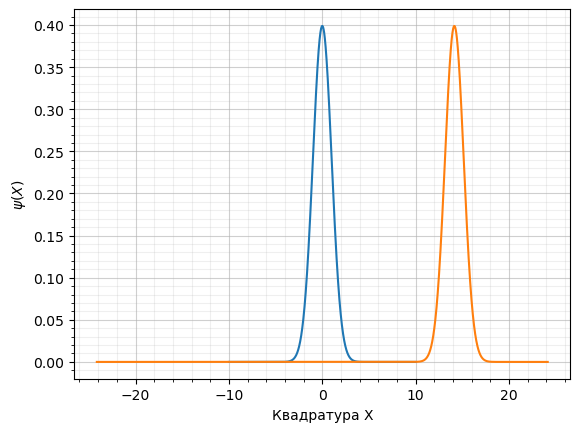

In [136]:
initial_state_mps = mp.asym_gauss_mps(x_left, x_right, n1, 1) + mp.asym_gauss_mps(x_bond2, x_bond2, n2, 1)
plt.plot(np.arange(-(2**n2)/2, (2**n2)/2) * step2, mp.tensors_multiplication(initial_state_mps[n1:]))
plt.plot(np.linspace(-x_left+x_bias, x_bias+x_right, 2**n1), mp.tensors_multiplication(initial_state_mps[:n1]))
plt.xlabel("Квадратура X")
plt.ylabel(r"$\psi(X)$")
plt.grid(which = 'major', alpha = 0.6)
plt.grid(which = 'minor', alpha = 0.2)
plt.minorticks_on()
plt.show()

### Количество тензоров в mps и mpo

In [139]:
len(final_mpo), len(initial_state_mps), len(mp.x_mps(n1 + n2))

(28, 28, 28)

### Вычисление эволюции моды накачки и моды сигнала под действием гамильтониана SPDC

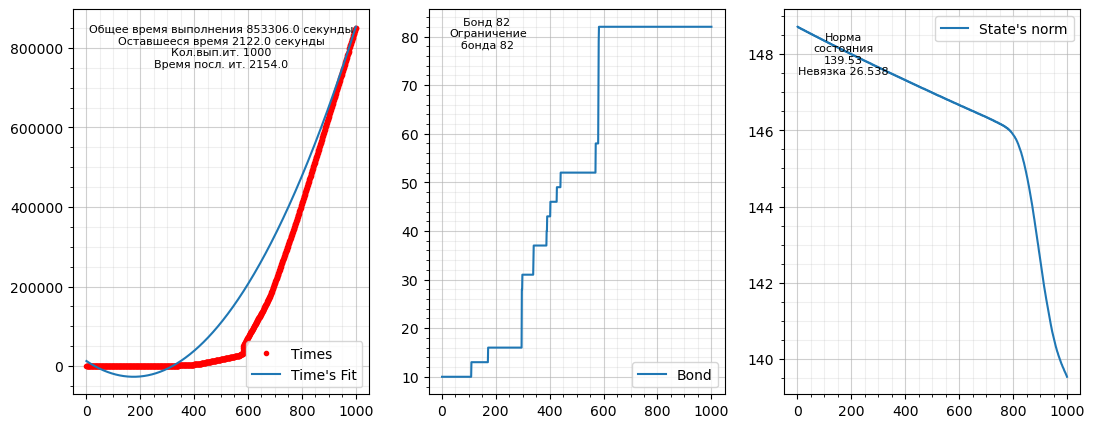

In [ ]:
set_of_solutions = mp.evolute10(initial_state_mps, final_mpo, steps_number, mp.mp_solve10, initial_guess=initial_guess, eps=eps, sweep_number=sweep_number, bond_limit=bond_limit, renormalize=False, way='')

### Построение графика бонда в ходе эволюции

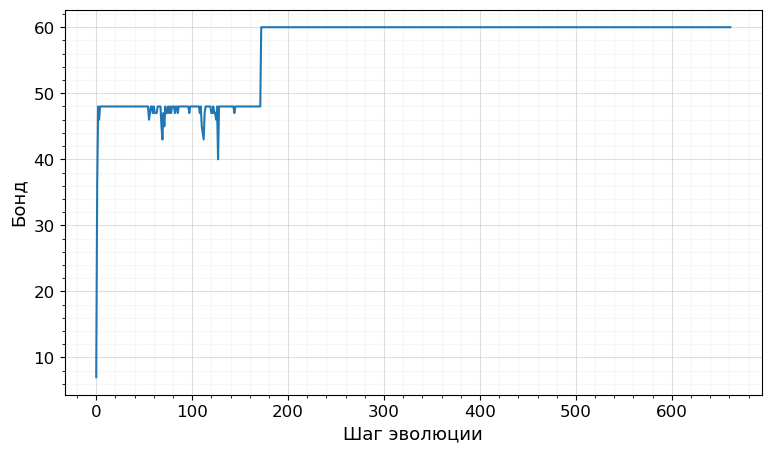

In [20]:
bonds = [mp.get_bond(solution) for solution in set_of_solutions2]
plt.figure(figsize=(9,5))
plt.grid(which = 'major', alpha = 0.4)
plt.grid(which = 'minor', alpha = 0.1)
plt.minorticks_on()
plt.xlabel("Шаг эволюции", fontsize=13)
plt.ylabel("Бонд", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(bonds)
plt.savefig("bond dimension")
plt.show()

### Вычисление эволюции числа фотонов под действием гамильтониана SPDC

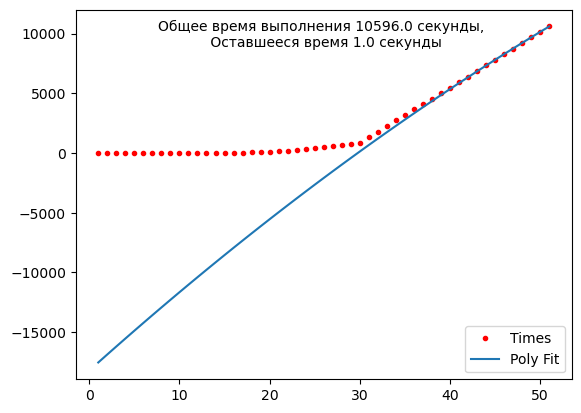

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [2:56:34<00:00, 207.74s/it]


In [ ]:
photon_number_dynamics = mp.calculate_photon_number_in_set_of_solutions(set_of_solutions[0], n1, n2, x_left, x_bond2, step1_v1, step2, x_bias, solver=mp.calculate_photon_number3, step=20)

### Построение графика эволюции числа фотонов

In [1]:
fig, ax1 = plt.subplots(figsize = (8,5))
plt.grid(alpha=0.4)
ax1.set_xlabel("Время, условные единицы", fontsize = 16)
ax1.set_ylabel("Число фотонов в моде", fontsize = 16)
line1, = ax1.plot(np.arange(len(photon_number_dynamics[0]))*0.001, np.array(photon_number_dynamics[0]), label = "Photons in pump mode (tensor networks)")
line2, = ax1.plot(np.arange(len(photon_number_dynamics[0]))*0.001, photon_number_dynamics[1], label = "Photons in signal mode (tensor networks)")
line3, = ax1.plot(np.arange(len(photon_number_dynamics[0]))*0.001, 2*np.array(photon_number_dynamics[0]) + np.array(photon_number_dynamics[1])-1.2, label = "Total energy of the system in the number of photons")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(0.035)
ax1.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('photon_dynamics.png', bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

### Построение матриц плотности обеих мод на конкретном шаге

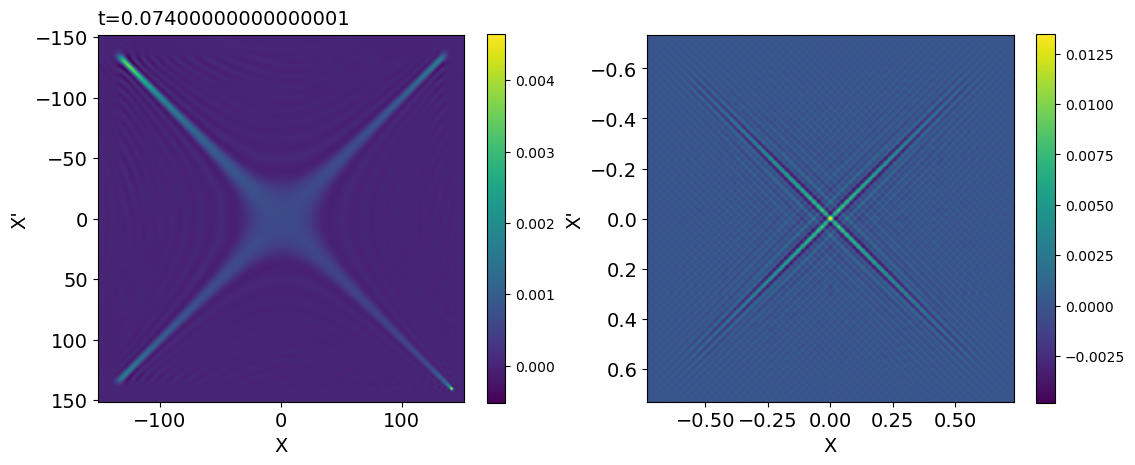

In [306]:
i = 37
cut_number = 150
signal_mode_center = 2048
pump_cut_number = 1024
cut_signal_ratio = cut_number/signal_mode_center
cut_pump_ratio = pump_cut_number/1024
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,6))
im1 = ax1.imshow(np.real(pump_matrices[i])[1024-pump_cut_number:1024, 1024-pump_cut_number:1024], extent = [(sp1[-1]-2*sp1[-1]*cut_pump_ratio), sp1[-1], sp1[-1], (sp1[-1]-2*sp1[-1]*cut_pump_ratio)])
im2 = ax2.imshow(np.real(signal_matrices[i])[signal_mode_center-cut_number:signal_mode_center+cut_number, signal_mode_center-cut_number:signal_mode_center+cut_number], extent = [sp2[0]*cut_signal_ratio, sp2[-1]*cut_signal_ratio, sp2[-1]*cut_signal_ratio, sp2[0]*cut_signal_ratio])
#plt.title("Матрица плотности сигнала, вычисленная двумя способами и представленная в непрерывном представлении")
#ax1.text(1.35, 1.27, f'Матрица плотности моды сигнала в ходе эволюции под дейсвтием гамильтониана SPDC, \n вычисленная двумя разными методами и представленная в непрерывном представлении', transform=ax1.transAxes, ha='center')
#ax1.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в координатном представлении \n с помощью тензорных сетей', transform=ax1.transAxes, ha='center')
#ax1.text(0.1, 0.9, f't={num_iter}', color = 'white', transform=ax1.transAxes, ha='center')
#ax2.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в Фоковском базисе \n и переведенная в координатное представление', transform=ax2.transAxes, ha='center')
ax2.text(-1.5, 1.03, f't={0.1*i/50}', color = 'black', transform=ax2.transAxes, fontsize = 14)
fig.colorbar(im1, ax=ax1, shrink=0.8)
fig.colorbar(im2, ax=ax2, shrink=0.8)
# ax1.set_xlabel('X-quadrature')
# ax1.set_ylabel('P-quadrature')
# ax2.set_xlabel('X-quadrature')
# ax2.set_ylabel('P-quadrature')
ax1.set_xlabel("X", fontsize = 14)
ax1.set_ylabel("X'", fontsize = 14)
ax2.set_xlabel("X", fontsize = 14)
ax2.set_ylabel("X'", fontsize = 14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('density_matrix_ttt_0.png', bbox_inches='tight')
plt.show()

## Сравнение эволюции в фоковском базисе и в непрерывном с т.с.

In [117]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/solutions_for_Fock_basis_alpha_10_photon_dynamics_#3_100000_steps.pkl', 'rb') as f:
    photon_dynamics_general = pickle.load(f)

In [118]:
fock_basis_ph_d = []
for i in range(0,len(photon_dynamics_general[0]),10):
    fock_basis_ph_d.append(photon_dynamics_general[0][i])

fock_basis_ph_d_2 = []
for i in range(0,len(photon_dynamics_general[0]),10):
    fock_basis_ph_d_2.append(photon_dynamics_general[1][i])

fock_basis_ph_d_3 = []
for i in range(0,len(fock_basis_ph_d_2),1):
    fock_basis_ph_d_3.append(2*fock_basis_ph_d_2[i]+fock_basis_ph_d[i])

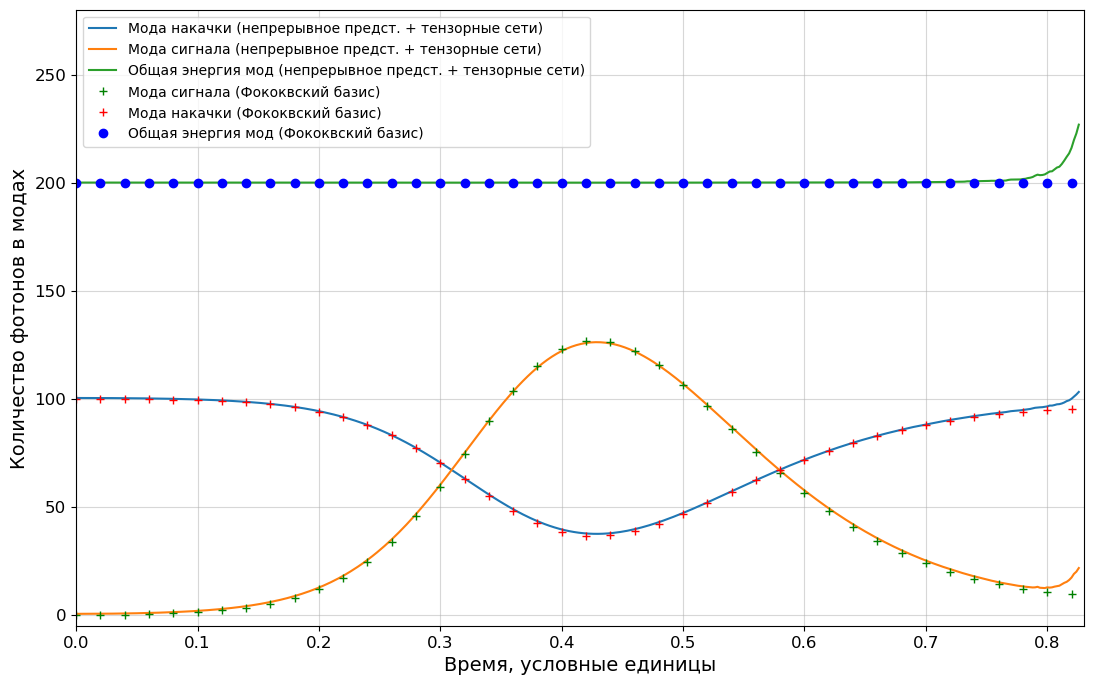

In [135]:
plt.figure(figsize = (13,8))
plt.grid(alpha=0.5)
#plt.title("Динамика числа фотонов в модах сигнала и накачки в ходе эволюции \n под действием гамильтониана вырожденного спонтанного параметрического рассеяния (SPDC), \n вычисленной в непрерывном представлении с помощью тензорных сетей и в Фоковском базисе")
plt.xlabel("Время, условные единицы", fontsize = 14)
plt.ylabel("Количество фотонов в модах", fontsize = 14)
plt.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.002, np.array(photon_number_dynamics[0][:-1]), label = "Мода накачки (непрерывное предст. + тензорные сети)")
plt.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.002, photon_number_dynamics[1][:-1], label = "Мода сигнала (непрерывное предст. + тензорные сети)")
plt.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.002, 2*np.array(photon_number_dynamics[0][:-1]) + np.array(photon_number_dynamics[1][:-1])-1.2, label = "Общая энергия мод (непрерывное предст. + тензорные сети)")
plt.plot(np.arange(len(fock_basis_ph_d))*0.02, fock_basis_ph_d, "g+", label = "Мода сигнала (Фококвский базис)")
plt.plot(np.arange(len(fock_basis_ph_d_2))*0.02, fock_basis_ph_d_2, "r+", label = "Мода накачки (Фококвский базис)")
plt.plot(np.arange(len(fock_basis_ph_d_3))*0.02, fock_basis_ph_d_3, "bo", label = "Общая энергия мод (Фококвский базис)", )
#plt.plot(np.arange(len(photon_dynamics_general[0]))*0.002, 200*np.ones(len(photon_dynamics_general[0])))
plt.xlim(0,0.83)
plt.ylim(-5,280)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
#plt.savefig('photon_d_for_thesis_2.png', bbox_inches='tight')
plt.show()

In [495]:
num_iter = 30
rho_1_tn = np.array(matrices[num_iter]/np.max(np.array(matrices[num_iter])))
rho_ph_b = np.array(rho_matrices_hp_basis[num_iter]/np.max(np.array(rho_matrices_hp_basis[num_iter])))

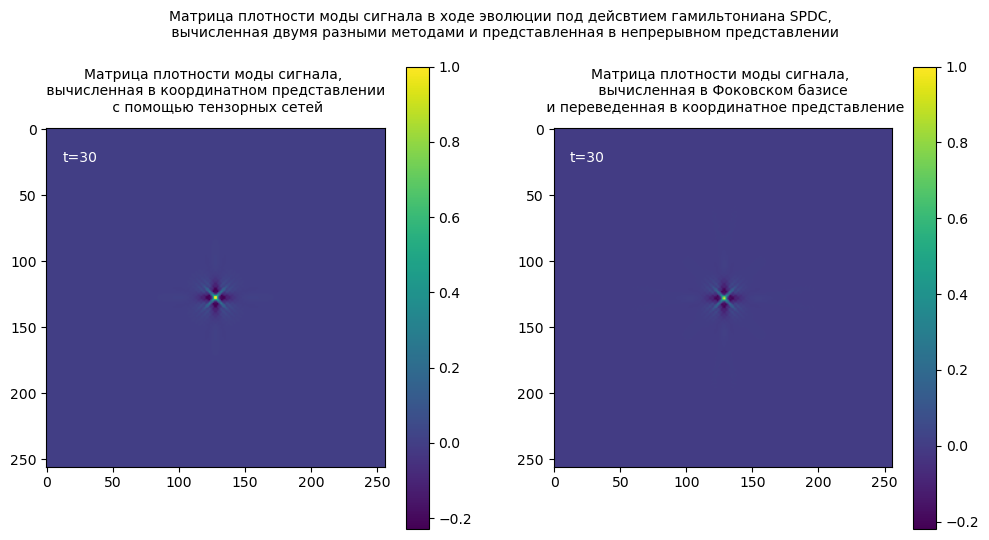

3.630868747011774

In [496]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
im1 = ax1.imshow(np.real(rho_1_tn))
im2 = ax2.imshow(np.real(rho_ph_b))
#plt.title("Матрица плотности сигнала, вычисленная двумя способами и представленная в непрерывном представлении")
ax1.text(1.35, 1.27, f'Матрица плотности моды сигнала в ходе эволюции под дейсвтием гамильтониана SPDC, \n вычисленная двумя разными методами и представленная в непрерывном представлении', transform=ax1.transAxes, ha='center')
ax1.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в координатном представлении \n с помощью тензорных сетей', transform=ax1.transAxes, ha='center')
ax1.text(0.1, 0.9, f't={num_iter}', color = 'white', transform=ax1.transAxes, ha='center')
ax2.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в Фоковском базисе \n и переведенная в координатное представление', transform=ax2.transAxes, ha='center')
ax2.text(0.1, 0.9, f't={num_iter}', color = 'white', transform=ax2.transAxes, ha='center')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()
np.linalg.norm(rho_1_tn, ord='fro')

## Перевод матрицы плотности из непрерывного базиса в Фоковский

In [2]:
n1 = 12
n2 = 13

In [3]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/list_of_solutions_with_tn_incr_n1n2_1e-3.pkl', 'rb') as f:
    set_of_solutions = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/list_of_solutions_with_tn_incr_n1n2_1e-3.pkl'

In [4]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/high_amplitude/list_of_solutions_with_tn_alpha_100_the_last_extended.pkl', 'rb') as f:
    set_of_solutions_high_amplitude = pickle.load(f)

In [5]:
number_of_elements = []
for mps in set_of_solutions:
    number_of_elements.append(mp.calculate_number_of_elements_in_MPS(mps))

In [33]:
number_of_elements_ha = []
for mps in set_of_solutions_high_amplitude:
    number_of_elements_ha.append(mp.calculate_number_of_elements_in_MPS(mps))

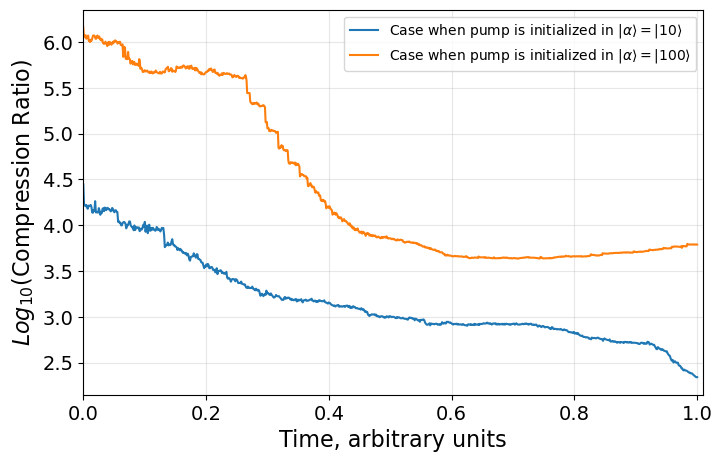

In [94]:
plt.figure(figsize = (8,5))
plt.plot(np.linspace(0, 1, len(number_of_elements)), np.log10(2**25/np.array(number_of_elements)), label = r'Case when pump is initialized in $|\alpha\rangle=|10\rangle$')
plt.plot(0.001*np.arange(len(number_of_elements_ha)), np.log10(2**30/np.array(number_of_elements_ha)), label = r'Case when pump is initialized in $|\alpha\rangle=|100\rangle$')
#plt.yscale('log')
plt.xlabel("Time, arbitrary units", fontsize = 16)
plt.ylabel(r"$Log_{10}$(Compression Ratio)", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(alpha=0.3)
plt.xlim(0,1.01)
#plt.ylim(0,10000)
plt.legend()
#plt.savefig('compression_ratio.png', bbox_inches='tight')
plt.show()

### Нахождение MPS для волновых функций Фоковских состояний

#### Необходимые функции для нахождения Фоковских состояний

In [867]:
def hermit_pol_3_comb(n, x):
    if n == 0:
        return 1 * np.exp(- x**2 / 2)
    elif n == 1:
        return 2 * x * np.exp(- x**2 / 2)

    h0 = 1
    h1 = 2 * x
    for i in range(2, n + 1):
        h = (2 * x * h1 - 2 * (i - 1) * h0)*(np.exp(- x**2 / 2))**(1/(n-1))
        h1 = h1 * (np.exp(- x**2 / 2))**(1/(n-1))
        h0, h1 = h1, h

    return h1

In [868]:
def psi_fock_3(n, x):
    # Calculate the logarithm of the factorial
    log_factorial_n = sum(np.log(np.arange(1, n + 1)))

    # Calculate the logarithm of the normalization factor
    log_norm = 0.5 * (n * np.log(2) + log_factorial_n + 0.5 * np.log(np.pi))

    # Calculate the Hermite polynomial
    hermite_value = hermit_pol_3_comb(n, x)

    # Combine the results
    result = hermite_value / np.exp(log_norm)

    return result

#### Вычисление волновых функций Фоковских состояний

In [945]:
fock_states = []
for i in tqdm(range(0,250)):
    fock_states.append(psi_fock_3(i, np.linspace(-10*np.sqrt(2)-10, 10*np.sqrt(2)+15, 2**12)))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 25.46it/s]


#### Нахождение MPS для волновых функций Фоковских состояний

In [941]:
fock_states_mps = []
for i in tqdm(range(0,250)):
    fock_states_mps.append(mp.vec_to_mps(fock_states[i], 1e-6))

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 451.98it/s]


#### Вычисление MPO для матрицы плотности состояний

In [909]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/2025-07-30_17-05-01/solutions.pkl', 'rb') as f:
    set_of_solutions = pickle.load(f)

In [910]:
len(set_of_solutions), len(set_of_solutions[0])

(901, 25)

In [946]:
column_matrix = np.vstack(fock_states).T
row_matrix = np.vstack(fock_states)

In [875]:
computed_matrices_signal = []
for k in tqdm(range(0, len(set_of_solutions), 20)):
    density_matrix = mp.find_reduced_density_matrix2(set_of_solutions[k], 1, n2, 0)
    density_matrix = density_matrix / np.trace(density_matrix)
    fock_basis_matrix = row_matrix @ density_matrix @ column_matrix
    computed_matrices_signal.append(fock_basis_matrix)

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:27<00:00,  4.51s/it]


In [880]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/2025-07-30_17-05-01/density_matrices_converted_to_Fb_signal.pkl', 'wb') as f:
    pickle.dump(computed_matrices_signal, f)

In [947]:
computed_matrices_pump = []
for k in tqdm(range(0, len(set_of_solutions), 20)):
    density_matrix = mp.find_reduced_density_matrix2(set_of_solutions[k], 0, n1, 0)
    density_matrix = density_matrix / np.trace(density_matrix)
    fock_basis_matrix = row_matrix @ density_matrix @ column_matrix
    computed_matrices_pump.append(fock_basis_matrix)

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [01:11<00:00,  1.56s/it]


In [950]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/2025-07-30_17-05-01/density_matrices_converted_to_Fb_pump.pkl', 'wb') as f:
    pickle.dump(computed_matrices_pump, f)

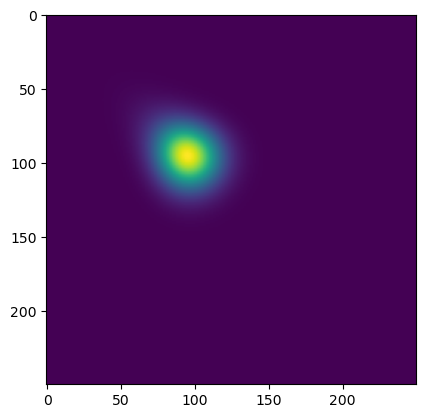

In [949]:
plt.imshow(computed_matrices_pump[10])
plt.show()

In [11]:
def create_dm_mpo_from_mps(mps):
    dm_mpo = []
    for i in range(len(mps)):
        tensor_combination = oe.contract("ijk, abc -> iajbkc", mps[i], np.conj(mps[i]), optimize = True)
        shape = tensor_combination.shape
        dm_mpo.append(tensor_combination.reshape(shape[0]*shape[1], shape[2], shape[3], shape[4]*shape[5]))
    return dm_mpo

In [12]:
def contract_mpo_and_two_mps(mps1, mps2, mpo, output = 'tensor'):
    mps_one = mps1.copy()
    mps_two = mps2.copy()
    mpo_use = mpo.copy()

    begin = mps_one[0].shape[0] * mps_two[0].shape[0] * mpo_use[0].shape[0]
    end = mps_one[-1].shape[-1] * mps_two[-1].shape[-1] * mpo_use[-1].shape[-1]

    result = np.array(1).reshape(1,1,1)
    if begin <= end:
        for i in range(len(mps1)):
            result = oe.contract("abc, ajk, bjgh, cgm -> khm", result, mps_one[i], mpo_use[i], mps_two[i], optimize = True)
    else:
        for i in range(len(mps1)):
            result = oe.contract("abc, ija, gjhb, phc -> igp", result, mps_one[-i-1], mpo_use[-i-1], mps_two[-i-1], optimize = True)
    if output == 'tensor':
        return result
    else:
        return result[0][0][0]

In [13]:
def contract_two_mps(mps1, mps2, output = "tensor"):
    mps_one = mps1.copy()
    mps_two = mps2.copy()

    begin = mps_one[0].shape[0] * mps_two[0].shape[0]
    end = mps_one[-1].shape[-1] * mps_two[-1].shape[-1]

    result = np.array(1).reshape(1,1)
    if begin <= end:
        for i in range(len(mps1)):
            result = oe.contract("ia, ijk, ajc -> kc", result, mps_one[i], mps_two[i], optimize = True)
    else:
        for i in range(len(mps1)):
            result = oe.contract("kc, ijk, ajc -> ia", result, mps_one[-i-1], mps_two[-i-1], optimize = True)
    if output == 'tensor':
        return result
    else:
        return result[0][0]

In [14]:
step_number = 200

In [17]:
final_density_matrices = []
for k in tqdm(range(0, len(set_of_solutions), 40)):
    environment = contract_two_mps(set_of_solutions[k][:n1], set_of_solutions[k][:n1])
    environment = environment.reshape(-1)
    density_matrix_mpo = create_dm_mpo_from_mps(set_of_solutions[k][n1:])
    final_density_matrix_mpo = density_matrix_mpo.copy()
    final_density_matrix_mpo[0] = np.einsum('i, ijkl -> jkl', environment, density_matrix_mpo[0])
    shape = final_density_matrix_mpo[0].shape
    final_density_matrix_mpo[0] = final_density_matrix_mpo[0].reshape(1, shape[0], shape[1], shape[2])
    length = 200
    dm_in_ph_basis = np.zeros((length,length), dtype = complex)
    for i in range(length):
        for j in range(length):
            second_move = contract_mpo_and_two_mps(fock_states_mps[i], fock_states_mps[j], final_density_matrix_mpo, output = 'number')
            dm_in_ph_basis[i,j] = second_move
    final_density_matrices.append(dm_in_ph_basis)
    #with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/transformaton_cv_density_m_to_FB/density_matrices_converted_to_Fb_№41.pkl', 'wb') as f:
        #pickle.dump(final_density_matrices, f)

  0%|                                                                                           | 0/21 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [117]:
computed_matrices_signal = []
for k in tqdm(range(0, len(set_of_solutions), 40)):
    environment = contract_two_mps(set_of_solutions[k][:n1], set_of_solutions[k][:n1])
    environment = environment.reshape(-1)
    density_matrix_mpo = create_dm_mpo_from_mps(set_of_solutions[k][n1:])
    final_density_matrix_mpo = density_matrix_mpo.copy()
    final_density_matrix_mpo[0] = np.einsum('i, ijkl -> jkl', environment, density_matrix_mpo[0])
    shape = final_density_matrix_mpo[0].shape
    final_density_matrix_mpo[0] = final_density_matrix_mpo[0].reshape(1, shape[0], shape[1], shape[2])
    matrix = mp.mpo_to_matrix(final_density_matrix_mpo)
    fock_basis_matrix = row_matrix @ matrix @ column_matrix
    computed_matrices_signal.append(fock_basis_matrix)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.69s/it]


In [143]:
computed_matrices_pump = []
for k in tqdm(range(0, len(set_of_solutions), 40)):
    environment = contract_two_mps(set_of_solutions[k][n1:], set_of_solutions[k][n1:])
    environment = environment.reshape(-1)
    density_matrix_mpo = create_dm_mpo_from_mps(set_of_solutions[k][:n1])
    final_density_matrix_mpo = density_matrix_mpo.copy()
    final_density_matrix_mpo[-1] = np.einsum('l, ijkl -> ijk', environment, density_matrix_mpo[-1])
    shape = final_density_matrix_mpo[-1].shape
    final_density_matrix_mpo[-1] = final_density_matrix_mpo[-1].reshape(shape[0], shape[1], shape[2], 1)
    matrix = mp.mpo_to_matrix(final_density_matrix_mpo)
    fock_basis_matrix = row_matrix @ matrix @ column_matrix
    computed_matrices_pump.append(fock_basis_matrix)

 62%|██████████████████████████████████████████████████▏                              | 13/21 [36:15<22:18, 167.37s/it]


KeyboardInterrupt: 

In [132]:
environment = contract_two_mps(set_of_solutions[1][n1:], set_of_solutions[1][n1:])
environment = environment.reshape(-1)
environment.shape

(4,)

In [133]:
density_matrix_mpo = create_dm_mpo_from_mps(set_of_solutions[1][:n1])
for i in density_matrix_mpo:
    print(i.shape)

(1, 2, 2, 1)
(1, 2, 2, 4)
(4, 2, 2, 9)
(9, 2, 2, 16)
(16, 2, 2, 36)
(36, 2, 2, 49)
(49, 2, 2, 49)
(49, 2, 2, 25)
(25, 2, 2, 16)
(16, 2, 2, 16)
(16, 2, 2, 9)
(9, 2, 2, 4)


In [136]:
final_density_matrix_mpo = density_matrix_mpo.copy()
final_density_matrix_mpo[-1] = np.einsum('l, ijkl -> ijk', environment, density_matrix_mpo[-1])
for i in final_density_matrix_mpo:
    print(i.shape)

(1, 2, 2, 1)
(1, 2, 2, 4)
(4, 2, 2, 9)
(9, 2, 2, 16)
(16, 2, 2, 36)
(36, 2, 2, 49)
(49, 2, 2, 49)
(49, 2, 2, 25)
(25, 2, 2, 16)
(16, 2, 2, 16)
(16, 2, 2, 9)
(9, 2, 2)


In [138]:
shape = final_density_matrix_mpo[-1].shape
final_density_matrix_mpo[-1] = final_density_matrix_mpo[-1].reshape(shape[0], shape[1], shape[2], 1)

In [139]:
for i in final_density_matrix_mpo:
    print(i.shape)

(1, 2, 2, 1)
(1, 2, 2, 4)
(4, 2, 2, 9)
(9, 2, 2, 16)
(16, 2, 2, 36)
(36, 2, 2, 36)
(36, 2, 2, 25)
(25, 2, 2, 16)
(16, 2, 2, 16)
(16, 2, 2, 9)
(9, 2, 2, 4)
(4, 2, 2, 1)


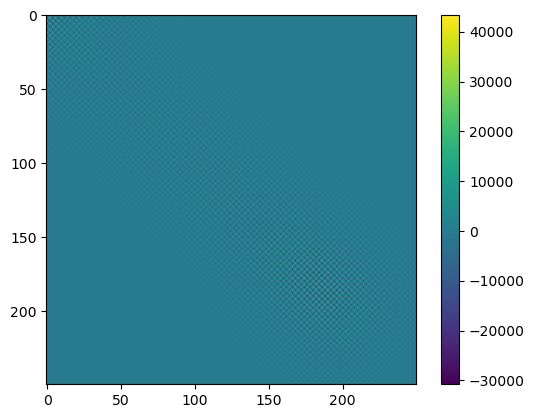

In [116]:
plt.imshow(computed_matrices_signal[10][:250, :250])
plt.colorbar()
plt.show()

In [632]:
final_density_matrices = []
for k in tqdm(range(0, len(set_of_solutions), 40)):
    environment = contract_two_mps(set_of_solutions[k][n1:], set_of_solutions[k][n1:])
    environment = environment.reshape(-1)
    density_matrix_mpo = create_dm_mpo_from_mps(set_of_solutions[k][:n1])
    final_density_matrix_mpo = density_matrix_mpo.copy()
    final_density_matrix_mpo[-1] = np.einsum('l, ijkl -> ijk', environment, density_matrix_mpo[-1])
    shape = final_density_matrix_mpo[-1].shape
    final_density_matrix_mpo[-1] = final_density_matrix_mpo[-1].reshape(shape[0], shape[1], shape[2], 1)
    length = 200
    dm_in_ph_basis = np.zeros((length,length), dtype = complex)
    for i in range(length):
        for j in range(length):
            second_move = contract_mpo_and_two_mps(fock_states_mps[i], fock_states_mps[j], final_density_matrix_mpo, output = 'number')
            dm_in_ph_basis[i,j] = second_move
    final_density_matrices.append(dm_in_ph_basis)
    #with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/transformaton_cv_density_m_to_FB/density_matrices_converted_to_Fb_№31.pkl', 'wb') as f:
        pickle.dump(final_density_matrices, f)

100%|█████████████████████████████████████████████████████████████████████████████| 21/21 [19:17:10<00:00, 3306.22s/it]


In [ ]:
# with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/density_matrices_converted_to_Fb.pkl', 'wb') as f:
#     pickle.dump(final_density_matrices, f)

In [ ]:
len(final_density_matrices)

In [ ]:
plt.imshow(final_density_matrices[10].real)
plt.colorbar()
plt.show()

In [90]:
with open('C:/Users/kaprn/Desktop/MPS_directory/TensorNetworks/Tests_of_spdc/Data_for_article/alpha_20_comparison/Selected_for_article/solutions_for_Fock_basis_alpha_10_#3_100000_steps.pkl', 'rb') as f:
    density_matrices_in_Fb = pickle.load(f)

In [108]:
density_matrices_initially_in_Fb = []
for i in range(0, len(density_matrices_in_Fb), 20):
    dm_Fb = density_matrices_in_Fb[i].reshape(300, 300)
    sol_U, sol_S, sol_V = np.linalg.svd(dm_Fb, full_matrices=False)
    density_matrix_one_fp = sol_U @ np.diag(sol_S) 
    density_matrix_one = density_matrix_one_fp @ np.conj(density_matrix_one_fp.T)
    
    density_matrix_two_fp = (np.diag(sol_S) @ sol_V).T 
    density_matrix_two = density_matrix_two_fp @ np.conj(density_matrix_two_fp.T)

    density_matrices_initially_in_Fb.append(density_matrix_two[:250, :250].real)